# Testing  HLS Fast Corner Detection Module

The HLS module performs 'fast corner detection'

The project builds on the VDMA demo.

## Project sources can be found here

[HLS Corner Detection](https://github.com/CospanDesign/pynq-hdl/tree/master/Projects/Simple%20HLS%20Corners%20VDMA)

In [1]:
import cv2
import numpy as np


def cvtcolor_rgb2yuv422(rgb):
    yuv422  =np.zeros((rgb.shape[0], rgb.shape[1], 2)).astype(np.uint8)
    yuv444 = cv2.cvtColor(rgb, cv2.COLOR_BGR2YUV);
    # chroma subsampling: yuv444 -> yuv422;
    for row in range(yuv444.shape[0]):
        for col in range(0, yuv444.shape[1], 2):
            p0_in = yuv444[row, col]
            p1_in = yuv444[row, col + 1]
            p0_out = [p0_in[0], p0_in[1]]
            p1_out = [p1_in[0], p0_in[2]]
            yuv422[row, col] = p0_out
            yuv422[row, col + 1] = p1_out
    
    return yuv422

# Open and Convert the Image to a usable format

Open the image and convert it to YUV422

Perform the conversion in a seperate cell than below because the conversion takes a long time.

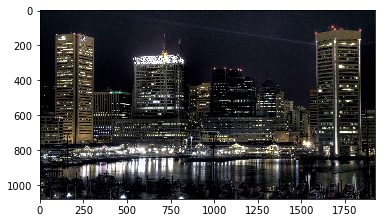

In [2]:
# %matplotlib inline 
from matplotlib import pyplot as plt


#Create a YUV422 Image So we don't need to keep regenerating it
IMAGE_FILE        = "../data/test_1080p.bmp"

image_in = cv2.imread(IMAGE_FILE)
image_yuv = cvtcolor_rgb2yuv422(image_in)

#SHOW IMAGE
image_out = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR_YUYV)
plt.imshow(image_out)
plt.show()


# Perform the Image Processing

1. Program the FPGA.
2. Configure the Egress and Ingress Video DMA cores and configure them to take in images with the with and height the same as the image opened.
3. Configure the Image Processor.
4. Send down the image to the memory accessable by the FPGA.
5. Intitate the VDMA Transfer.
6. Wait for the transfer to finish.
7. Read back and display the image

Image Size: 1920x1080
Frame width, height: 1920, 1080

Running? Egress:Ingress False:False
Enabling One of the Engine
Running? Egress:Ingress False:True

Enabling Both Engines

Both of the engines should be halted after transferring one frame
Running? Egress:Ingress False:False

Disabling both engines
Running? Egress:Ingress False:False


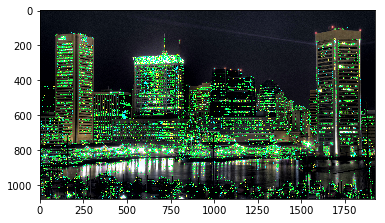

In [8]:
# %matplotlib inline 

from time import sleep
from pynq import Overlay
from pynq.drivers import VDMA
from image_processor import ImageProcessor
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np


#Constants
BITFILE_NAME      = "hls_corners.bit"
EGRESS_VDMA_NAME  = "SEG_axi_vdma_0_Reg"
INGRESS_VDMA_NAME = "SEG_axi_vdma_1_Reg"
HLS_NAME          = "SEG_image_filter_0_Reg"


# Set Debug to true to enable debug messages from the VDMA core
DEBUG = False
#DEBUG = True

# Set Verbose to true to dump a lot of messages about
VERBOSE = False
#VERBOSE = True

#These can be set between 0 - 2, the VDMA can also be configured for up to 32 frames in 32-bit memspace and 16 in 64-bit memspace
EGRESS_FRAME_INDEX  = 0
INGRESS_FRAME_INDEX = 0

IMAGE_WIDTH = image_yuv.shape[1]
IMAGE_HEIGHT = image_yuv.shape[0]

print ("Image Size: %dx%d" % (IMAGE_WIDTH, IMAGE_HEIGHT))

#Download Images
ol = Overlay(BITFILE_NAME)
ol.download()



vdma_egress  = VDMA(name = EGRESS_VDMA_NAME,  debug = DEBUG)
vdma_ingress = VDMA(name = INGRESS_VDMA_NAME, debug = DEBUG)
image_processor = ImageProcessor(HLS_NAME)
image_processor.set_image_width(IMAGE_WIDTH)
image_processor.set_image_height(IMAGE_HEIGHT)
image_processor.enable(True)

#print ("Image Processor Enabled? %s" % image_processor.is_enabled())




#Set the size of the image
vdma_egress.set_image_size(IMAGE_WIDTH, IMAGE_HEIGHT, color_depth = 2)
vdma_ingress.set_image_size(IMAGE_WIDTH, IMAGE_HEIGHT, color_depth = 2)

#The above functions created the video frames

#Populate the frame
frame = vdma_egress.get_frame(EGRESS_FRAME_INDEX)
frame.set_bytearray(bytearray(image_yuv.astype(np.int8).tobytes()))


print ("Frame width, height: %d, %d" % (frame.width, frame.height))

print ("")

print ("Running? Egress:Ingress %s:%s" % (vdma_egress.is_egress_enabled(), vdma_ingress.is_ingress_enabled()))


if VERBOSE:
    vdma_egress.dump_egress_registers()
    vdma_ingress.dump_ingress_registers()
    print ("")
print ("Enabling One of the Engine")

#Open Up the Ingress Side
vdma_ingress.start_ingress_engine(  continuous  = False,
                                    num_frames  = 1,
                                    frame_index = INGRESS_FRAME_INDEX,
                                    interrupt   = False)


if VERBOSE:
    vdma_egress.dump_egress_registers()
    vdma_ingress.dump_ingress_registers()

print ("Running? Egress:Ingress %s:%s" % (vdma_egress.is_egress_enabled(), vdma_ingress.is_ingress_enabled()))


print ("")
print ("Enabling Both Engines")

#Quick Start
vdma_egress.start_egress_engine(    continuous  = False,
                                    num_frames  = 1,
                                    frame_index = EGRESS_FRAME_INDEX,
                                    interrupt   = False)


print ("")
print ("Both of the engines should be halted after transferring one frame")

#XXX: I think this sleep isn't needed but the core erroniously reports an engine isn't finished even though it is.
#XXX: This sleep line can be commented out but the egress core may report it is not finished.
sleep(0.1)

if VERBOSE:
    vdma_egress.dump_egress_registers()
    vdma_ingress.dump_ingress_registers()

print ("Running? Egress:Ingress %s:%s" % (vdma_egress.is_egress_enabled(), vdma_ingress.is_ingress_enabled()))

if VERBOSE:
    print ("Egress WIP:  %d" % vdma_egress.get_wip_egress_frame())
    print ("Ingress WIP: %d" % vdma_ingress.get_wip_ingress_frame())

#Check to see if the egress frame point progressed

print ("")
print ("Disabling both engines")

#Disable both
vdma_egress.stop_egress_engine()
vdma_ingress.stop_ingress_engine()

print ("Running? Egress:Ingress %s:%s" % (vdma_egress.is_egress_enabled(), vdma_ingress.is_ingress_enabled()))

if VERBOSE:
    vdma_egress.dump_egress_registers()
    vdma_ingress.dump_ingress_registers()
    print ("Egress Error:  0x%08X" % vdma_egress.get_egress_error())
    print ("Ingress Error: 0x%08X" % vdma_ingress.get_ingress_error())

frame = vdma_ingress.get_frame(INGRESS_FRAME_INDEX)
#frame.save_as_jpeg("./image.jpg")


image_yuv_out = np.ndarray(  shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 2),
                        dtype=np.uint8,
                        buffer = frame.get_bytearray())


image_rgb_out = cv2.cvtColor(image_yuv_out, cv2.COLOR_YUV2BGR_YUYV)
#SHOW IMAGE
plt.imshow(image_rgb_out)
plt.show()


